<a href="https://colab.research.google.com/github/Mingrui-Wang/Inverse-of-a-Matrix/blob/master/double_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import os
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive/暑期科研/"

os.chdir(path)
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['9total_y.npy',
 '9total_x.npy',
 'normal_hard.npy',
 'normal_hard_label.npy',
 'N_A_H_label.npy',
 'N_A_H.npy',
 'Anomaly_label.npy',
 'Anomaly.npy',
 'chromosome_9_label.npy',
 'chromosome_9.npy',
 'chromosome_harddata_label.npy',
 'chromosome_harddata.npy',
 '测试集_label.npy',
 '测试集.npy',
 '训练集_label.npy',
 '训练集.npy',
 '训练集500_label.npy',
 '训练集500.npy',
 '训练集400.npy',
 '训练集400_label.npy',
 '训练集300_label.npy',
 '训练集300.npy',
 'my_model.h5']

In [27]:
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from keras.preprocessing import image
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout, UpSampling2D
import os

x_train_savepath = './训练集500.npy'
y_train_savepath = './训练集500_label.npy'

print('-------------Load Datasets-----------------')
x_train_save = np.load(x_train_savepath)
y_train = np.load(y_train_savepath)

x_train = np.reshape(x_train_save, (len(x_train_save), 150, 150,1))


x_train = x_train.astype('float32')

# x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
# x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)

#

-------------Load Datasets-----------------
(843, 150, 150, 1)


In [28]:
x_test = x_train[668:843]
x_train_new = x_train[0:668]
x_train = x_train_new
len(x_test)

175

In [29]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras import Model

np.set_printoptions(threshold=np.inf)

x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.reshape(x_train.shape[0], 150, 150, 1)  # 给数据增加一个维度，使数据和网络结构匹配
x_test = x_test.reshape(x_test.shape[0], 150, 150, 1)  # 给数据增加一个维度，使数据和网络结构匹配


print("x_train.shape", x_train.shape)
print("x_test.shape", x_test.shape)

x_train.shape (668, 150, 150, 1)
x_test.shape (175, 150, 150, 1)


In [5]:
class Autoencoder():
    def __init__(self):

        self.img_shape = (150,150,1)

        optimizer = Adam(lr=0.001)

        self.autoencoder_model = self.build_model()
        self.autoencoder_model.compile(loss='binary_crossentropy', optimizer=optimizer)
        self.autoencoder_model.summary()

    def build_model(self):
        input_layer = Input(shape=self.img_shape)

        # encoder
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
        h = MaxPooling2D((2, 2), padding='same')(h)
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
        h = MaxPooling2D((3, 3), padding='same')(h)

        # decoder
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
        h = UpSampling2D((3, 3))(h)
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
        h = UpSampling2D((2, 2))(h)

        output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(h)

        return Model(input_layer, output_layer)

    def train_model(self, x_train, y_train, x_test, y_test, epochs, batch_size):
        early_stopping = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=5,
                                       verbose=1,
                                       mode='auto')
        history = self.autoencoder_model.fit(x_train, x_train,
                                             batch_size=batch_size,
                                             epochs=epochs,
                                             validation_data=(x_test, x_test),
                                             callbacks=[early_stopping])
        
        file = self.autoencoder_model.save_weights('my_model.h5')

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

    def eval_model(self, x_test):
        preds = self.autoencoder_model.predict(x_test)
        return preds


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 75, 75, 64)       

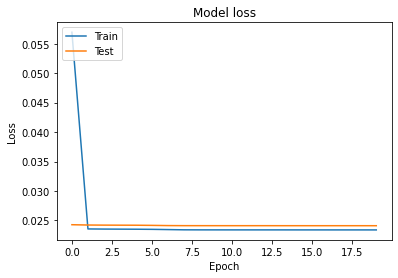

In [6]:
ae_1 = Autoencoder()
ae_1.train_model(x_train, x_train, x_test, x_test, epochs=20, batch_size=3)

In [7]:
decoded_test = ae_1.eval_model(x_test)
### get the error term of all testing dataset images
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
#scale it
scaled_input_test = scaler.fit_transform(x_test.reshape(-1,22500))
#scale it
scaled_output_test = scaler.fit_transform(decoded_test.reshape(-1,22500))

In [8]:
### get the error term of all training set images

# Firstly, we get the decoder image of training set.
decoded_train = ae_1.eval_model(x_train)

from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
#scale it
scaled_input_train = scaler.fit_transform(x_train.reshape(-1,22500))
#scale it
scaled_output_train = scaler.fit_transform(decoded_train.reshape(-1,22500))

In [9]:
import pandas as pd
sequences = range(1,844)
from keras import losses
x = losses.binary_crossentropy(scaled_input_train,scaled_output_train)
y = losses.binary_crossentropy(scaled_input_test,scaled_output_test)

In [10]:
seqs_ds = pd.DataFrame(sequences)
mse = np.append(x,y)
seqs_ds['binary_crossentropy'] = mse
seqs_ds

,0,binary_crossentropy
0,1,1.293572
1,2,1.229438
2,3,1.166682
3,4,1.172451
4,5,1.242020
...,...,...
838,839,2.376131
839,840,2.305871
840,841,2.399316
841,842,2.544230


In [11]:
threshold = len(x_train)/(len(x_train)+len(x_test))
threshold

0.7924080664294187

In [12]:
binary_crossentropy_threshold = np.quantile(seqs_ds['binary_crossentropy'], threshold)
print(f'binary_crossentropy threshhold:{binary_crossentropy_threshold}')

binary_crossentropy threshhold:1.6142469131225456


In [13]:
seqs_ds['binary_crossentropy_Outlier'] = 0
seqs_ds.loc[seqs_ds['binary_crossentropy'] > binary_crossentropy_threshold, 'binary_crossentropy_Outlier'] = 1
print(f"Num of binary_crossentropy outlier:{seqs_ds['binary_crossentropy_Outlier'].sum()}")

seqs_ds[seqs_ds['binary_crossentropy_Outlier']==1]

Num of binary_crossentropy outlier:175


,0,binary_crossentropy,binary_crossentropy_Outlier
668,669,2.303293,1
669,670,2.633298,1
670,671,2.411116,1
671,672,2.373261,1
672,673,2.670181,1
...,...,...,...
838,839,2.376131,1
839,840,2.305871,1
840,841,2.399316,1
841,842,2.544230,1


In [14]:
hard_data_detection_acc = len(seqs_ds[seqs_ds['binary_crossentropy_Outlier']==1])/175
print(hard_data_detection_acc)

1.0


In [56]:
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from keras.preprocessing import image
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout, UpSampling2D
import os

x_train_savepath = './训练集500.npy'
y_train_savepath = './训练集500_label.npy'

print('-------------Load Datasets-----------------')
x_train_save = np.load(x_train_savepath)
y_train = np.load(y_train_savepath)

x_train = np.reshape(x_train_save, (len(x_train_save), 150, 150,1))


x_train = x_train.astype('float32')

# x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
# x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)

#

-------------Load Datasets-----------------
(843, 150, 150, 1)


In [57]:
x_test = x_train[500:668]
x_train_new = x_train[0:500]
x_train = x_train_new
len(x_test)

168

In [58]:
class Autoencoder_2():
    def __init__(self):

        self.img_shape = (150,150,1)

        optimizer = Adam(lr=0.001)

        self.autoencoder_model = self.build_model()
        self.autoencoder_model.compile(loss='binary_crossentropy', optimizer=optimizer)
        self.autoencoder_model.summary()

    def build_model(self):
        input_layer = Input(shape=self.img_shape)

        # encoder
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
        h = MaxPooling2D((2, 2), padding='same')(h)
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
        h = MaxPooling2D((3, 3), padding='same')(h)

        # decoder
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
        h = UpSampling2D((3, 3))(h)
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
        h = UpSampling2D((2, 2))(h)

        output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(h)

        return Model(input_layer, output_layer)

    def train_model(self, x_train, y_train, x_test, y_test, epochs, batch_size):
        early_stopping = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=5,
                                       verbose=1,
                                       mode='auto')
        history = self.autoencoder_model.fit(x_train, x_train,
                                             batch_size=batch_size,
                                             epochs=epochs,
                                             validation_data=(x_test, x_test),
                                             callbacks=[early_stopping])
        
        file = self.autoencoder_model.save_weights('my_model.h5')

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

    def eval_model(self, x_test):
        preds = self.autoencoder_model.predict(x_test)
        return preds


Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 150, 150, 1)]     0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 150, 150, 64)      640       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 75, 75, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 25, 25, 64)        36928     
_________________________________________________________________
up_sampling2d_10 (UpSampling (None, 75, 75, 64)      

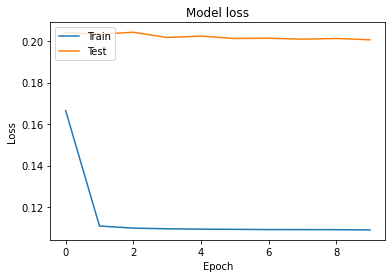

In [59]:
ae_2 = Autoencoder_2()
ae_2.train_model(x_train, x_train, x_test, x_test, epochs=10, batch_size=4)

In [60]:
decoded_test = ae_2.eval_model(x_test)
### get the error term of all testing dataset images
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
#scale it
scaled_input_test = scaler.fit_transform(x_test.reshape(-1,22500))
#scale it
scaled_output_test = scaler.fit_transform(decoded_test.reshape(-1,22500))

In [61]:
### get the error term of all training set images

# Firstly, we get the decoder image of training set.
decoded_train = ae_2.eval_model(x_train)

from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
#scale it
scaled_input_train = scaler.fit_transform(x_train.reshape(-1,22500))
#scale it
scaled_output_train = scaler.fit_transform(decoded_train.reshape(-1,22500))

In [63]:
import pandas as pd
sequences = range(1,669)
from keras import losses
x = losses.binary_crossentropy(scaled_input_train,scaled_output_train)
y = losses.binary_crossentropy(scaled_input_test,scaled_output_test)

In [64]:
seqs_ds = pd.DataFrame(sequences)
mse = np.append(x,y)
seqs_ds['binary_crossentropy'] = mse
seqs_ds

,0,binary_crossentropy
0,1,0.983718
1,2,0.905509
2,3,0.939022
3,4,0.933644
4,5,0.862003
...,...,...
663,664,1.726189
664,665,1.688992
665,666,1.568315
666,667,1.544441


In [65]:
threshold = 500/668
threshold

0.7485029940119761

In [66]:
binary_crossentropy_threshold = np.quantile(seqs_ds['binary_crossentropy'], threshold)
print(f'binary_crossentropy threshhold:{binary_crossentropy_threshold}')

binary_crossentropy threshhold:1.1109544224367884


In [67]:
seqs_ds['binary_crossentropy_Outlier'] = 0
seqs_ds.loc[seqs_ds['binary_crossentropy'] > binary_crossentropy_threshold, 'binary_crossentropy_Outlier'] = 1
print(f"Num of binary_crossentropy outlier:{seqs_ds['binary_crossentropy_Outlier'].sum()}")

seqs_ds[seqs_ds['binary_crossentropy_Outlier']==1]

Num of binary_crossentropy outlier:168


,0,binary_crossentropy,binary_crossentropy_Outlier
500,501,1.657972,1
501,502,1.663194,1
502,503,1.653664,1
503,504,1.502996,1
504,505,1.600064,1
...,...,...,...
663,664,1.726189,1
664,665,1.688992,1
665,666,1.568315,1
666,667,1.544441,1


In [72]:
anomaly_data_detection_acc = len(seqs_ds[seqs_ds['binary_crossentropy_Outlier']==1])/168
print(anomaly_data_detection_acc)

1.0
